In [1]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as enSentiment
from GerVADER.vaderSentimentGER import SentimentIntensityAnalyzer as gerSentiment
import re
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('IchBinHanna.csv')

In [3]:
#prepare data, drop retweets and split it into german and english tweets
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(rem_url)
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]

In [4]:
#use VADER (source: https://github.com/cjhutto/vaderSentiment) to analyse the sentiment of english tweets
analyser_en = enSentiment()
df_en['sentiment scores'] = df_en['text'].apply(analyser_en.polarity_scores)

In [5]:
#use GerVADER(source: https://github.com/KarstenAMF/GerVADER)
analyser_ger = gerSentiment()
df_ger['sentiment scores'] = df_ger['text'].apply(analyser_ger.polarity_scores)

In [6]:
#split scores into separate columns
df_en = pd.concat([df_en.drop(['sentiment scores'], axis=1), df_en['sentiment scores'].apply(pd.Series)], axis=1)
df_ger = pd.concat([df_ger.drop(['sentiment scores'], axis=1), df_ger['sentiment scores'].apply(pd.Series)], axis=1)
#rejoin data frames
df_sentiment = pd.concat([df_en,df_ger])

In [7]:
#number of tweets left
df_sentiment.shape[0]

24503

In [8]:
#some descriptive statistics
print("Max Sentiment scores:\n neg:{0}\n neu:{1}\n pos:{2}\n compound:{3}".format(df_sentiment['neg'].max(), df_sentiment['neu'].max(), df_sentiment['pos'].max(), df_sentiment['compound'].max()))
print("Mean Sentiment scores:\n neg:{0}\n neu:{1}\n pos:{2}\n compound:{3}".format(round(df_sentiment['neg'].mean(),4), round(df_sentiment['neu'].mean(),4), round(df_sentiment['pos'].mean(),4), round(df_sentiment['compound'].mean(),4)))

Max Sentiment scores:
 neg:1.0
 neu:1.0
 pos:1.0
 compound:0.9832
Mean Sentiment scores:
 neg:0.0545
 neu:0.8316
 pos:0.1139
 compound:0.213


In [9]:
#VADERs documentation suggests that scores below -0.05 imply a negative, between -0.05 and 0.05 a neutral and above a positive sentiment
conditions = [(df_sentiment['compound'] <= -0.05), (df_sentiment['compound'] > -0.05) & (df_sentiment['compound'] < 0.05),(df_sentiment['compound'] > 0.05)]
values = ['negative', 'neutral', 'positive']
df_sentiment['sentiment'] = np.select(conditions, values)
df_sentiment['sentiment'].value_counts()

positive    14177
negative     5450
neutral      4875
0               1
Name: sentiment, dtype: int64

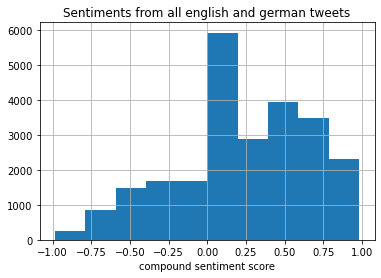

In [10]:
#distribution of overall sentiment scores
df_sentiment['compound'].hist()
plt.title('Sentiments from all english and german tweets')
plt.xlabel('compound sentiment score')
plt.show()